In [2]:
import pandas as pd
import numpy as np
import tqdm as tqdm
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Circle

### Import all the data

In [5]:
WRK="/workdir/users/pd378/oil_international/args_prevelence/custom_card_search/"
KMA="/workdir/users/pd378/oil_international/args_prevelence/kma_metagenomic_profiling/"
# table from humaan results that groups RGI best hits into groups based on the kma cd-hit results
gene_rep_fams=pd.read_csv(KMA+"output_files/card_data/aro_to_aro_rep.txt",sep='\t')
# curated list of selected gene families
selected_gene_fams=pd.read_csv(KMA+"output_files/metadata/selected_gene_fams_V1.txt", sep='\t')
gene_fam_meta=pd.merge(left=selected_gene_fams, right=gene_rep_fams, on=["AMR Gene Family","Resistance Mechanism"], how='outer')
# all the rgi data combined into a single file and prefiltered to remove loose hits and only keep protein homolog model varients

In [2]:
RGI_COMBO="/home/britolab/refdbs/genbank_bacterial_genomes_22-2-11/combined_rgi_output_file/header_loose_filtered_rgi_results.cat.txt"
rgi_out=pd.read_csv(RGI_COMBO, sep='\t')
rgi_out=rgi_out.reset_index().rename({"index":"file"}, axis=1)
print(len(rgi_out))
rgi_out=rgi_out.drop_duplicates() # I expect some duplicates becasue of how I prepared the files
print(len(rgi_out))
rgi_out=rgi_out[rgi_out["Model_type"]=="protein homolog model"]
print(len(rgi_out))


#parse the assembly number for merging in metadata
rgi_out["# assembly_accession"]=rgi_out['file'].str.split('_', 2).str[1]
rgi_out["# assembly_accession"]="GCA_"+rgi_out["# assembly_accession"]

12566274
12566274
10852307


#### Bring in all the genome information that I compiled when selecting the genomes to process

In [6]:
# the table used to select genomes for downloading
genome_info=pd.read_csv(WRK+"genbank_download_prep/compile_download_list/22-2-14_genbank_bacterial_FURTHUR_exclusion_filtered.txt", sep='\t')
# remove brackets around the genus name in the parsed genu
genome_info["tax_name_genus"]=genome_info["tax_name_genus"].str.strip("[").str.strip("]")
#remove instances where the taxonomy genus doesn't match the geneus in the taxa name (lose 624 genomes)
genome_info=genome_info[genome_info["genus"]==genome_info["tax_name_genus"]]
#double check that all have genus informaiton
genome_info=genome_info[~genome_info["genus"].isna()]
genome_info["year"]=genome_info["seq_rel_date"].str.split("/").str[0]
print(len(genome_info)) #965336

genome_info["genus_2"]=genome_info["tax_name"].str.split(" ").str[0].str.strip("[").str.strip("]")
genome_info["species_2"]=genome_info["tax_name"].str.split(" ").str[1].str.strip("[").str.strip("]")
genome_info["tax_name_2"]=genome_info["genus_2"]+" "+genome_info["species_2"]


### also import a list of all the genomes that were processed to I have an accurate count of the total number of genomes
genomes_processed=pd.read_csv(WRK+"rgi_analysis/publication_tabs/list_of_all_processed_genomes.txt", names=["file"])
genomes_processed["# assembly_accession"]=genomes_processed['file'].str.split('_', 2).str[1]
genomes_processed["# assembly_accession"]="GCA_"+genomes_processed["# assembly_accession"]
print(len(genomes_processed))
genomes_processed=pd.merge(left=genomes_processed, right=genome_info, on="# assembly_accession", how='left')
print(len(genomes_processed))

965336
589890
589890


In [7]:
pathogens=pd.read_csv(WRK+"rgi_analysis/publication_tabs/card_pathogens.txt",sep='\t')
pathogen_list=pathogens["pathogen"].to_list()

########## some of the genera are maked as both pathogens and not pathogens...

## slow code to decide if something is a pthogen or not
patho_list=[]
non_patho_list=[]
for index, row in genomes_processed.iterrows():
    #default is no anotation
    patho=0
    non=0
    #check if in the pathogen list
    if row["tax_name_2"] in pathogen_list:
        patho=1
    # if not, then check if there is any entry for species before marking non-pathogenic 
    elif row["species_2"]=="sp.":
        non=0
    elif row["species_2"]==row["species_2"]: # will be false if value is nan
        non=1

    patho_list.append(patho)
    non_patho_list.append(non)
genomes_processed["pathogen"]=patho_list
genomes_processed["non_pathogen"]=non_patho_list
genomes_processed.head(2)
genomes_processed.to_csv(WRK+'rgi_analysis/publication_tabs/all_processed_genomes_with_metadata.txt',sep='\t')

In [19]:
genomes_processed.groupby('class').size().reset_index(name='total_genomes')

,class,total_genomes
0,Abditibacteria,1
1,Acidimicrobiia,17
2,Acidithiobacillia,102
3,Acidobacteriia,51
4,Actinomycetia,24140
...,...,...
80,Tichowtungiia,1
81,Tissierellia,207
82,Verrucomicrobiae,318
83,Vicinamibacteria,1


In [5]:
# combine all the information into a single table
print(len(rgi_out))
hit_df=pd.merge(left=rgi_out, right=genome_info, on="# assembly_accession", how='inner')
hit_df["ARO"]="ARO:"+hit_df["ARO"].astype(str)
print(len(hit_df))
keep_compiled_cols=['file','ARO','Model_type','taxid','species_taxid','organism_name','infraspecific_name',
                    'isolate','version_status','assembly_level','release_type','genome_rep','seq_rel_date','asm_name','submitter','excluded_from_refseq',
                    'relation_to_type_material','asm_not_live_date','superkingdom','kingdom','phylum','class','order','family','genus','species',
                    'tax_name','tax_name_genus','year']
hit_df=pd.merge(left=gene_fam_meta, right=hit_df[keep_compiled_cols].rename({"ARO":"aro"}, axis=1), on=["aro"], how='inner')
print(len(hit_df))
# there could be instances where one genome has multiple ARGs that all group into the same representative. I gotta remove these
hit_df=hit_df.drop_duplicates(["file","aro_rep"])
print(len(hit_df))
hit_df.to_csv(WRK+"rgi_analysis/publication_tabs/full_compiled_genbank_reults.txt",sep='\t',index=False)
hit_df.head(4)

10852307
10850780
10473877
9257848


,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,aro_rep,ARO Name,...,kingdom,phylum,class,order,family,genus,species,tax_name,tax_name_genus,year
0,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,ARO:3002528,AAC(3)-Ia,...,NaN,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter baumannii,Acinetobacter baumannii AB0057,Acinetobacter,2017
1,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,ARO:3002528,AAC(3)-Ia,...,NaN,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter baumannii,Acinetobacter baumannii UMB001,Acinetobacter,2010
2,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,ARO:3002528,AAC(3)-Ia,...,NaN,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter baumannii,Acinetobacter baumannii MDR-ZJ06,Acinetobacter,2018
3,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,ARO:3002528,AAC(3)-Ia,...,NaN,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter baumannii,Acinetobacter baumannii ABNIH22,Acinetobacter,2013


In [6]:
print("total genomes_processed: "+str(len(genomes_processed)))
print("total genomes with RGI hits: "+str(len(rgi_out["file"].drop_duplicates())))
print("total genomes after RGI filter: "+str(len(hit_df["file"].drop_duplicates())))

total genomes_processed: 589890
total genomes with RGI hits: 542985
total genomes after RGI filter: 542622


In [7]:
# delete this df becase its massive and isn't used again
del rgi_out

In [1]:
hit_df[hit_df['display_name']=='NDM']

NameError: name 'hit_df' is not defined

### What are the most commonly observed genes?
* I can look at abundance in genomes vs metagenomes to see if a correlation

In [ ]:
detected_genes_per_family=hit_df[["ARO Name","AMR Gene Family"]].drop_duplicates()#.groupby("AMR Gene Family").size().reset_index(name="gene_count")
#total_card_clusters=card_reps[["ARO Name","AMR Gene Family"]].drop_duplicates().groupby("AMR Gene Family").size().reset_index(name="total_count")
#detected_genes_per_family=pd.merge(left=detected_genes_per_family, right=total_card_clusters, on="AMR Gene Family", how='outer')
select_genes_per_family=pd.merge(left=selected_gene_fams, right=detected_genes_per_family, on="AMR Gene Family", how='left').fillna(0)
select_genes_per_family=select_genes_per_family.sort_values(["Grouping","grouped_family","display_name"], key=lambda col: col.str.lower())
drop_fams=["APH(2''); AAC(6')","EC beta-lactamase","AAC(6')-Ib-cr"]
select_genes_per_family=select_genes_per_family[~select_genes_per_family["AMR Gene Family"].isin(drop_fams)]
select_genes_per_family

In [277]:
detected_genes_per_family=hit_df[["AMR Gene Family","ARO Name"]].drop_duplicates()#.groupby("AMR Gene Family").size().reset_index(name="gene_count")
detected_genes_per_family.to_csv(WRK+"rgi_analysis/publication_tabs/rgi_detected_gene_culters.txt",sep='\t',index=False)
detected_genes_per_family

,AMR Gene Family,ARO Name
0,AAC(3),AAC(3)-Ia
3198,AAC(3),AAC(3)-Ib
3261,AAC(3),AAC(3)-Ic
3397,AAC(3),AAC(3)-Id
3793,AAC(3),AAC(3)-IIa
...,...,...
10473585,viomycin phosphotransferase,vph
10473630,BlaA beta-lactamase,y56 beta-lactamase
10473781,YEM beta-lactamase,YEM-1
10473795,YRC Beta-lactamase,Yrc-1


In [8]:
hit_df.groupby(["ARO Name"]).size().reset_index(name="count").sort_values("count",ascending=False).head(5)

,ARO Name,count
1005,rsmA,233986
225,CRP,230665
858,emrB,218879
389,Klebsiella pneumoniae KpnF,216904
860,emrR,212275


## Heatmap for gene families by taxa group
* collect infomration about taxonomic spread of each gene family 


In [9]:
import warnings
warnings.filterwarnings("ignore")

tax_level=["phylum","class","order","family","genus"]

################## enter the desired taxonomic level for the heatmap here ###################
tax="class"

#collect info about total number of isolates
total_tax_counts=genomes_processed.copy().drop_duplicates(["file"])
total_tax_counts["dummy"]=1
total_tax_counts[tax+"_count"]=total_tax_counts.groupby(tax)["dummy"].transform('sum')
total_tax_counts["patho_count"]=total_tax_counts.groupby(tax)["pathogen"].transform('sum')
total_tax_counts["non_patho_count"]=total_tax_counts.groupby(tax)["non_pathogen"].transform('sum')
total_tax_counts["percent_patho"]=100*total_tax_counts["patho_count"]/total_tax_counts[tax+"_count"]
total_tax_counts["percent_non_patho"]=100*total_tax_counts["non_patho_count"]/total_tax_counts[tax+"_count"]
total_tax_counts=total_tax_counts[[tax,tax+"_count","patho_count","non_patho_count","percent_patho","percent_non_patho"]].drop_duplicates()
total_tax_counts["total_percent"]=total_tax_counts["percent_patho"]+total_tax_counts["percent_non_patho"]


#gene_fam_abundance=hit_df_reduced.drop_duplicates(["file","AMR Gene Family"])
#gene_fam_abundance["dummy"]=1
#gene_fam_abundance[tax+"_count"]=gene_fam_abundance.groupby(tax)["dummy"].transform('sum')

gene_fam_abundance=hit_df.copy().drop_duplicates(["file","AMR Gene Family"])
gene_fam_abundance=gene_fam_abundance.groupby([tax,"AMR Gene Family",'grouped_family']).size().reset_index(name="gene_fam_count")

gene_fam_abundance=pd.merge(left=gene_fam_abundance, right=total_tax_counts[[tax,tax+"_count"]], on=tax, how='left')
gene_fam_abundance[tax+"_prevelence"]=100*gene_fam_abundance["gene_fam_count"]/gene_fam_abundance[tax+"_count"]
print(len(gene_fam_abundance[tax].drop_duplicates()))

min_taxa_reps=10
gene_fam_abundance=gene_fam_abundance[gene_fam_abundance[tax+"_count"] >= min_taxa_reps]
print(len(gene_fam_abundance[tax].drop_duplicates()))

# minimum number of detections for an association to be considered real
min_detections=2
gene_fam_abundance=gene_fam_abundance[gene_fam_abundance["gene_fam_count"] >= min_detections]
print(len(gene_fam_abundance[tax].drop_duplicates()))

33
29
24


In [10]:
gene_fam_abundance.head()

,class,AMR Gene Family,grouped_family,gene_fam_count,class_count,class_prevelence
1,Actinomycetia,AAC(3),aminoglycoside acetyltransferase,346,24140.0,1.433306
2,Actinomycetia,AAC(6'),aminoglycoside acetyltransferase,177,24140.0,0.733223
3,Actinomycetia,ANT(3''),aminoglycoside nucleotidyltransferase,202,24140.0,0.836785
5,Actinomycetia,ANT(6),aminoglycoside nucleotidyltransferase,13,24140.0,0.053853
6,Actinomycetia,APH(3''),aminoglycoside phosphotransferase,196,24140.0,0.811930


In [11]:
pivot_df=pd.merge(left=selected_gene_fams, right=gene_fam_abundance, on=["grouped_family","AMR Gene Family"], how='inner').fillna(0)
pivot_df=pivot_df.pivot_table(index=tax, columns=['Grouping','grouped_family',"display_name"], values=tax+ "_prevelence").T#.droplevel(0,axis=1).T
# sort the genes ignoring case and grouping properly
pivot_df=pivot_df.sort_index(key=lambda col: col.str.lower()).droplevel([0,1],axis=0)

In [12]:
total_fam_per=pivot_df.sum(axis=1).reset_index().sort_values(0)
min_percent=0
drop_count=0
print(len(pivot_df.columns))
for column in pivot_df.columns:
    # Filer the data to reduce number of low abundant taxa
    # If the sum of abundace across all countries is less then 10%, it is removed
    if pivot_df[column].sum() < min_percent:
        pivot_df.drop(column, axis=1, inplace=True)
        drop_count+=1
        
total_fam_per=pivot_df.sum(axis=1).reset_index().sort_values(0)
pivot_df=pivot_df.fillna(0.00001)
print(len(pivot_df.columns))
print(drop_count)

24
24
0


### Prepare plasmid markings

In [13]:
# import the taxa-gene plasmid detections I curated using CARD and NCBI data
plasmids_taxa=pd.read_csv(WRK+"rgi_analysis/publication_tabs/all_rgi_and_card_plasmid_detections.txt", sep='\t')

# merge in the selected gene groups
plasmids_taxa=pd.merge(left=selected_gene_fams, right=plasmids_taxa, on=["AMR Gene Family"], how='inner').fillna(0)
plasmids_taxa["detect"]=1
#some of the taxonomies are undefined...
plasmids_taxa=plasmids_taxa[plasmids_taxa["class"]!=0]
# drop duplicate detections to just the taxonomic level chosen
plasmid_matrix=plasmids_taxa[[tax,"display_name","detect"]].drop_duplicates()

#picot the table
plasmid_matrix=plasmid_matrix.pivot_table(index="display_name", columns=tax, values="detect").fillna(0)

### Can I make the tree and graph it in python?

In [14]:
### AMAZING CODE FROM HERE
### https://gist.github.com/fransua/da703c3d2ba121903c0de5e976838b71

from itertools import chain

from matplotlib.collections import LineCollection
from matplotlib import markers
from matplotlib.path import Path
import math

import numpy as np

from ete3 import Tree, NodeStyle

def round_sig(x, sig=2):
    return round(x, sig - int(math.floor(np.log10(abs(x)))) - 1)


def to_coord(x, y, xmin, xmax, ymin, ymax, plt_xmin, plt_ymin, plt_width, plt_height):
    x = (x - xmin) / (xmax - xmin) * plt_width  + plt_xmin
    y = (y - ymin) / (ymax - ymin) * plt_height + plt_ymin
    return x, y


def plot_tree(tree, align_names=False, name_offset=None, max_dist=None, font_size=9, axe=None, **kwargs):
    """
    Plots a ete3.Tree object using matploltib.
    
    :param tree: ete Tree object
    :param False align_names: if True names will be aligned vertically
    :param None max_dist: if defined any branch longer than the given value will be 
       reduced by this same value.
    :param None name_offset: offset relative to tips to write leaf_names. In bL scale
    :param 12 font_size: to write text
    :param None axe: a matploltib.Axe object on which the tree will be painted.
    :param kwargs: for tree edge drawing (matplotlib LineCollection) 
    :param 1 ms: marker size for tree nodes (relative to number of nodes)
    
    :returns: a dictionary of node objects with their coordinates
    """
    
    if axe is None:
        axe = plt.subplot(111)

    
    def __draw_edge_nm(c, x):
        h = node_pos[c]
        hlinec.append(((x, h), (x + c.dist, h)))
        hlines.append(cstyle)
        return (x + c.dist, h)

    def __draw_edge_md(c, x):
        h = node_pos[c]
        if c in cut_edge:
            offset = max_x / 600.
            hlinec.append(((x, h), (x + c.dist / 2 - offset, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + offset, h), (x + c.dist, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2, h - 0.05), (x + c.dist / 2 - 2 * offset, h + 0.05)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + 2 * offset, h - 0.05), (x + c.dist / 2, h + 0.05)))
            hlines.append(cstyle)
            axe.text(x + c.dist / 2, h - 0.07, '+%g' % max_dist, va='top', 
                     ha='center', size=2. * font_size / 3)
        else:
            hlinec.append(((x, h), (x + c.dist, h)))
            hlines.append(cstyle)
        return (x + c.dist, h)

    __draw_edge = __draw_edge_nm if max_dist is None else __draw_edge_md
    
    vlinec = []
    vlines = []
    hlinec = []
    hlines = []
    nodes = []
    nodex = []
    nodey = []
    ali_lines = []
    
    # to align leaf names
    tree = tree.copy()
    max_x = max(n.get_distance(tree) for n in tree.iter_leaves())

    coords = {}
    node_pos = dict((n2, i) for i, n2 in enumerate(tree.get_leaves()[::-1]))
    node_list = tree.iter_descendants(strategy='postorder')
    node_list = chain(node_list, [tree])

    # reduce branch length
    cut_edge = set()
    if max_dist is not None:
        for n in tree.iter_descendants():
            if n.dist > max_dist:
                n.dist -= max_dist
                cut_edge.add(n)

    if name_offset is None:
        name_offset = max_x / 100.
    # draw tree
    for n in node_list:
        style = n._get_style()
        x = __builtin__.sum(n2.dist for n2 in n.iter_ancestors()) + n.dist
        if n.is_leaf():
            y = node_pos[n]
            if align_names:
                axe.text(max_x + name_offset, y, n.name, 
                         va='center', size=font_size)
                ali_lines.append(((x, y), (max_x + name_offset, y)))
            else:
                axe.text(x + name_offset, y, n.name,
                         va='center', size=font_size)
        else:
            y = np.mean([node_pos[n2] for n2 in n.children])
            node_pos[n] = y

            # draw vertical line
            vlinec.append(((x, node_pos[n.children[0]]), (x, node_pos[n.children[-1]])))
            vlines.append(style)

            # draw horizontal lines
            for child in n.children:
                cstyle = child._get_style()
                coords[child] = __draw_edge(child, x)
        nodes.append(style)
        nodex.append(x)
        nodey.append(y)

    # draw root
    __draw_edge(tree, 0)

    lstyles = ['-', '--', ':']
    hline_col = LineCollection(hlinec, colors=[l['hz_line_color'] for l in hlines], 
                              linestyle=[lstyles[l['hz_line_type']] for l in hlines],
                              linewidth=[(l['hz_line_width'] + 1.) / 2 for l in hlines])
    vline_col = LineCollection(vlinec, colors=[l['vt_line_color'] for l in vlines], 
                              linestyle=[lstyles[l['vt_line_type']] for l in vlines],
                              linewidth=[(l['vt_line_width'] + 1.) / 2 for l in vlines])
    ali_line_col = LineCollection(ali_lines, colors='k')

    axe.add_collection(hline_col)
    axe.add_collection(vline_col)
    axe.add_collection(ali_line_col)

    nshapes = dict((('circle', 'o'), ('square', 's'), ('sphere', 'o')))
    shapes = set(n['shape'] for n in nodes)
    for shape in shapes:
        indexes = [i for i, n in enumerate(nodes) if n['shape'] == shape]
        scat = axe.scatter([nodex[i] for i in indexes], 
                           [nodey[i] for i in indexes], 
                           s=0, marker=nshapes.get(shape, shape))
        scat.set_sizes([(nodes[i]['size'])**2 / 2 for i in indexes])
        scat.set_color([nodes[i]['fgcolor'] for i in indexes])
        scat.set_zorder(10)

    # scale line
    xmin, xmax = axe.get_xlim()
    ymin, ymax = axe.get_ylim()
    diffy = ymax - ymin
    dist = round_sig((xmax - xmin) / 5, sig=1)
    ymin -= diffy / 100.
    axe.plot([xmin, xmin + dist], [ymin, ymin], color='k')
    axe.plot([xmin, xmin], [ymin - diffy / 200., ymin + diffy / 200.], color='k')
    axe.plot([xmin + dist, xmin + dist], [ymin - diffy / 200., ymin + diffy / 200.], 
             color='k')
    axe.text((xmin + xmin + dist) / 2, ymin - diffy / 200., dist, va='top',
             ha='center', size=font_size)
    axe.set_axis_off()
    return coords

######## old code for turnign the NCBI tree into newick format

#full_tree=Tree(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.phy"")
#newick=""
#with open(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.phy") as fp:
#    for line in fp.readlines():   
#        this_line=line.strip()
#        if ")" in this_line:
#            right_count+=1
#       #     this_line=this_line.lstrip(")")
#        #    this_line="),"+this_line
#        if "(" in this_line:
#            left_count+=1
#        newick=newick+this_line

#text_file = open(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.nwk", "w")
#n = text_file.write(newick)
#text_file.close()


In [15]:
from ete3 import Tree

# read the tree I already formatted
# * removed the distance ':4', all apostrophies, and a few instances of names with parentheses 
### I have to add some missing families by hand :(
tree=Tree(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.nwk", format=8)
parent_child=[["Hyphomicrobiales","Bartonellaceae"],['Verrucomicrobiales','Akkermansiaceae'],['Actinomycetia','Mycobacteriales'],
              ['Mycobacteriales','Corynebacteriaceae'],['Rhodocyclales','Fluviibacteraceae'], ['Oceanospirillales','Oleiphilaceae'],
              ['Corynebacteriales','Tsukamurellaceae'], ['Erysipelotrichales','Turicibacteraceae']]
for pair in parent_child:
    node = tree.search_nodes(name=pair[0])
    node[0].add_child(name=pair[1])

In [16]:
prune_tree=tree.copy()
# prune the tree to the taxa in my dataset
prune_tree.prune(pivot_df.columns.to_list())
# get the taxa names in the order of the tree
leaves=prune_tree.get_leaf_names()
# reverse the order to match graphing function
leaves=[x for x in reversed(leaves)]
ordered_taxa=pd.DataFrame(index=leaves)
# reorder the dataframe based on the taxa list
ordered_pivot_df=pd.merge(left=ordered_taxa, right=pivot_df.T, left_index=True, right_index=True, how='left')

# order the bars based on the taxonomic tree
ordered_bars=pd.DataFrame(ordered_pivot_df.index, columns=[tax])
ordered_bars=pd.merge(left=ordered_bars, right=total_tax_counts, on=tax, how='left')
ordered_bars["hundo"]=100

# order the plasmid matrix based on the heatmap and tree
plasmid_ordered=pd.merge(left=pd.DataFrame(index=ordered_pivot_df.columns.to_list()), right=plasmid_matrix, left_index=True, right_index=True, how='left')
plasmid_ordered=pd.merge(left=ordered_taxa, right=plasmid_ordered.T, left_index=True, right_index=True, how='left').fillna(0)

#calculate the coordinates for anotating the plasmids
i=0
p_coord_list=[]
for index, row in plasmid_ordered.iterrows(): #first loop will be secont coord
    j=0
    for item in row:#second loop will be first coord
        if item > 0:
            p_coord_list.append((j+0.5,i+0.5))
        j+=1
    i+=1

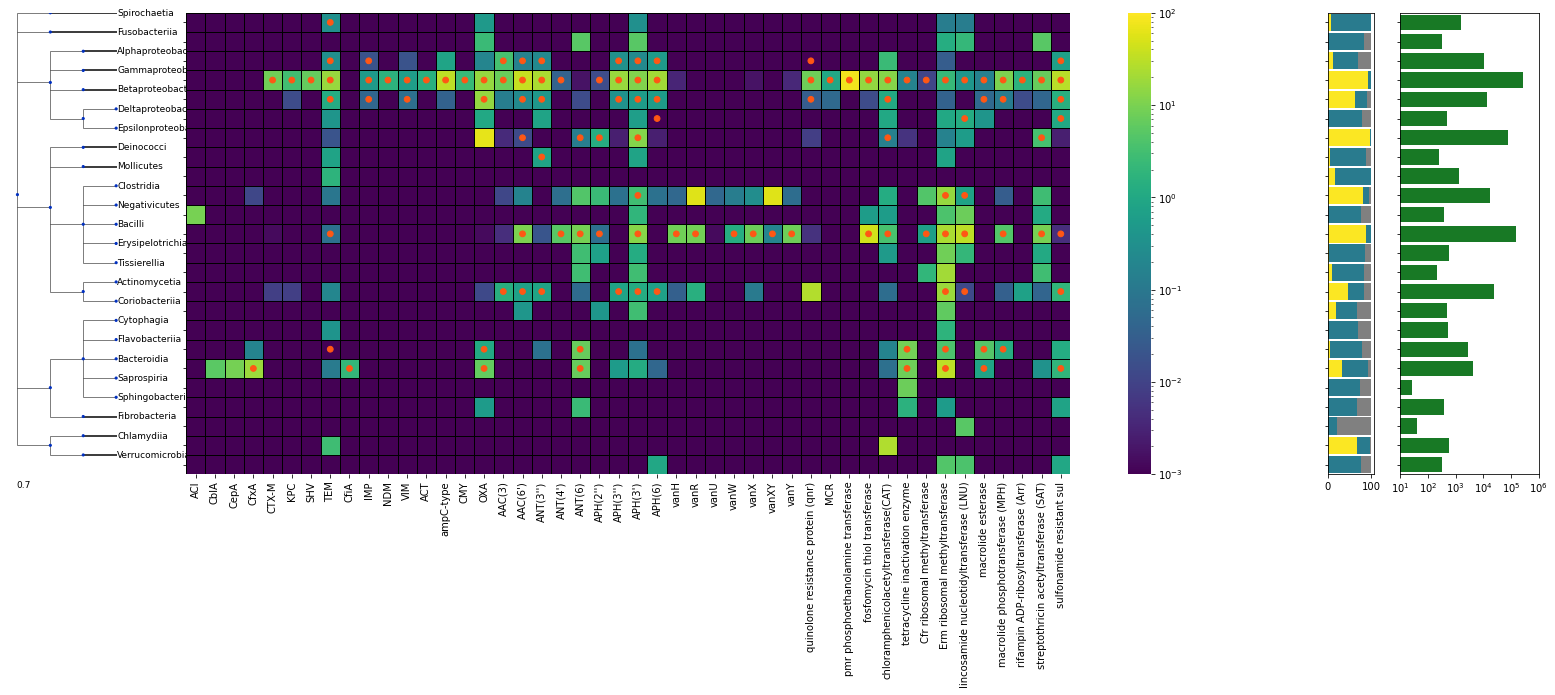

In [17]:
fig, ax = plt.subplots(1,4, figsize=(22,7), sharey='row', gridspec_kw={'width_ratios': [1,10,0.4,1.2]})
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()

# bars showing proportion pathogens
y_ticks = ordered_bars[tax]
y_tick_pos = [i + 0.5 for i in range(len(y_ticks))]
color=['#fbe723','#297b8e']
ax[2].barh(y_tick_pos, ordered_bars["hundo"], height=0.9, align='center', color='grey')
ax[2].barh(y_tick_pos, ordered_bars["total_percent"], height=0.9, align='center', color=color[1])
ax[2].barh(y_tick_pos, ordered_bars["percent_patho"], height=0.9, color=color[0])
ax[2].set_yticks(y_tick_pos)

# bars showing total isolates
ax[3].barh(y_tick_pos, ordered_bars[tax+"_count"], align='center', color="#187925")
#axi[i].barh(y_tick_pos, bar_data["not_healthy_country_count"], color=color[0])
ax[3].set_yticks(y_tick_pos)
ax[3].set_xscale('log')   
ax[3].set_xticks([10,100,1000,10000,100000,1000000])

#heatmap
sns.heatmap(ordered_pivot_df, cmap='viridis', linewidth=1, linecolor='black', ax=ax[1], norm=LogNorm(vmin=0.001, vmax=100), square=True)
coords = plot_tree(prune_tree, align_names=True, name_offset=None, max_dist=3, font_size=9, axe=ax[0])

## add plasmid markings
edge_colors=['#CC5803',"#FF5714"]
for coord in p_coord_list: 
    ax[1].add_patch(Circle(coord, radius=0.15, color=edge_colors[1]))#, 1, 1, fill=False, edgecolor=edge_colors[3], lw=2))


plt.savefig(WRK+"rgi_analysis/figures/finalish_heatmaps/full_analysis_reorder_"+tax+"_level_bars_heatmap.png")
plt.savefig(WRK+"rgi_analysis/figures/finalish_heatmaps/full_analysis_reorder_"+tax+"_level_bars_heatmap.svg")

In [18]:
len(ordered_pivot_df.index)

24

# Comparing the global prevelence VS the isolates results
* Try using the maximum phylogentic distance for each gene

In [19]:
dist_df=hit_df[~hit_df["display_name"].isna()]
dist_df=dist_df[['AMR Gene Family', 'display_name', 'Resistance Mechanism','grouped_family','Antibioitic Types',
        'Grouping','mechansim_and_beta_lactams', 'scatter_groups', 'aro_rep', 'ARO Name',
        'genus','phylum','class','order','family','tax_name','tax_name_genus']].drop_duplicates()

dist_df["tax_name_genus"]=dist_df["tax_name_genus"].str.strip("[").str.strip("]")
#remove instances where the taxonomy genus doesn't match the geneus in the taxa name (lose 624 genomes)
dist_df=dist_df[dist_df["genus"]==dist_df["tax_name_genus"]]
dist_df=dist_df[~dist_df["genus"].isna()]

dist_df["genus"]=dist_df["tax_name"].str.split(" ").str[0].str.strip("[").str.strip("]")
dist_df["detect"]=1
dist_df=dist_df[plasmids_taxa.columns.to_list()]
print(len(dist_df))
dist_df=dist_df.append(plasmids_taxa)
print(len(dist_df))
dist_df.head(2)

53869
55237


,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus,phylum,class,order,family,detect
0,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,AAC(3)-Ia,Acinetobacter,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,1
1,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,AAC(3)-Ia,Acinetobacter,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,1


### Load in a tree for all bacteria to calculate distances between phyla

In [223]:

ranks=pd.read_csv(WRK+"bacterial_lineage_tree/metadata/ranks.tsv",sep='\t').set_index("genome")

# compile nodes for all the genera I have results for
detect_genera=dist_df["genus"].drop_duplicates().to_list()
detect_nodes_tax=ranks[ranks["genus"].isin(detect_genera)]
detect_node_names=detect_nodes_tax.index.to_list()

# count the total number of nodes representing each genus
def group_and_count(df, groupings, name):
    return df.groupby(groupings).size().reset_index(name=name)
total_genus_nodes=group_and_count(detect_nodes, ['phylum','class','order','family','genus'], "genus_count").set_index("genus")

In [259]:
bt = Tree(WRK+"bacterial_lineage_tree/trees/full_tree.nwk", format=1)
for leaf in bt.iter_leaves():
    tax_series=ranks.loc[leaf.name]
    leaf.add_features(Kingdom=tax_series["kingdom"],
                      Phylum=tax_series["phylum"],
                      Class=tax_series["class"],
                      Order=tax_series["order"],
                      Family=tax_series["family"],
                      Genus=tax_series["genus"])

In [271]:
for genus, df in detect_nodes_tax.groupby("genus"):
    g_nodes=get_name_nodes(df.index.to_list())
    if len(g_nodes)<=1: continue
    print(bt.check_monophyly(values=g_nodes, target_attr="Genus", ignore_missing=True))

TreeError: 'Nodes are not connected!'

In [270]:
get_name_nodes(df.index.to_list())[1].Genus

'Acetivibrio'

In [262]:
df

,kingdom,phylum,class,order,family,genus,species
genome,,,,,,,
G900112085,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Acetitomaculum,Acetitomaculum ruminis


In [235]:
bt = Tree(WRK+"bacterial_lineage_tree/trees/full_tree.nwk", format=1)
keep_nodes=[]
for leaf in bt.iter_leaves():
    if leaf.name in detect_node_names:
        keep_nodes.append(leaf)
        tax_series=ranks.loc[leaf.name]
        leaf.add_features(Kingdom=tax_series["kingdom"],
                          Phylum=tax_series["phylum"],
                          Class=tax_series["class"],
                          Order=tax_series["order"],
                          Family=tax_series["family"],
                          Genus=tax_series["genus"])

In [206]:
bt.prune(keep_nodes)

In [218]:
def recurse_nodes(node):
    if node.is_leaf():
        tax_dict={node.Genus:1}
        return tax_dict
    
    else:
        child1_dict=recurse_nodes(node.children[0])
        child2_dict=recurse_nodes(node.children[1])
        node_dict=dict(Counter(child1_dict)+Counter(child2_dict))
        node.add_features(count_dict=node_dict)
        return node_dict

In [219]:
pt=bt.copy()
recurse_nodes(pt)

{'Meiothermus': 6,
 'Thermus': 11,
 'Deinococcus': 21,
 'Collinsella': 8,
 'Enorma': 2,
 'Atopobium': 18,
 'Eggerthella': 5,
 'Gordonibacter': 1,
 'Frankia': 9,
 'Blastococcus': 3,
 'Stackebrandtia': 1,
 'Glycomyces': 3,
 'Micromonospora': 3,
 'Actinoplanes': 7,
 'Nakamurella': 2,
 'Dietzia': 3,
 'Lawsonella': 2,
 'Corynebacterium': 110,
 'Mycobacterium': 61,
 'Nocardia': 30,
 'Rhodococcus': 13,
 'Actinoalloteichus': 1,
 'Saccharopolyspora': 3,
 'Actinopolyspora': 3,
 'Kibdelosporangium': 1,
 'Actinophytocola': 1,
 'Actinokineospora': 3,
 'Goodfellowiella': 1,
 'Saccharothrix': 4,
 'Umezawaea': 1,
 'Amycolatopsis': 8,
 'Prauserella': 1,
 'Saccharomonospora': 9,
 'Jiangella': 3,
 'Actinopolymorpha': 1,
 'Tessaracoccus': 1,
 'Propionibacterium': 3,
 'Propionimicrobium': 1,
 'Cutibacterium': 7,
 'Aeromicrobium': 5,
 'Nocardioides': 18,
 'Pimelobacter': 1,
 'Microbispora': 2,
 'Nonomuraea': 3,
 'Streptosporangium': 2,
 'Actinomadura': 5,
 'Nocardiopsis': 15,
 'Streptomonospora': 1,
 'Strep

In [215]:
from collections import Counter
x = {'both1':1, 'both2':2, 'only_x': 100 }
y = {'both1':10, 'both2': 20, 'only_y':200 }

z = dict(Counter(x)+Counter(y))
print(z)

{'both1': 11, 'both2': 22, 'only_x': 100, 'only_y': 200}


In [155]:


# annotate the tree with the taxa
for leaf in bt.iter_leaves():
    tax_series=ranks.loc[leaf.name]
    leaf.add_features(Kingdom=tax_series["kingdom"],
                      Phylum=tax_series["phylum"],
                      Class=tax_series["class"],
                      Order=tax_series["order"],
                      Family=tax_series["family"],
                      Genus=tax_series["genus"])
    

In [244]:
def get_name_nodes(name_list):
    name_nodes=[]
    for n in name_list:
        name_nodes=name_nodes+bt.search_nodes(name=n)
    return name_nodes

def get_node_list(tax_list):
    tax_nodes=[]
    for t in tax_list:
        tax_nodes=tax_nodes+bt.search_nodes(Genus=t)
    return tax_nodes
        
def get_max_dist(node_list, print=False):
    ancestor=bt.get_common_ancestor(node_list)
    dist_list=[]
    for node in node_list:
        node_dist=ancestor.get_distance(node)
        dist_list.append(node_dist)

    #sort the list largest to smallest and the sum of the top two will be the max distance
    dist_list.sort(reverse=True)
    if len(dist_list)==1: 
        max_dist=0 
    else: 
        max_dist=dist_list[0]+dist_list[1]
    
    return max_dist

In [175]:
all_leaves=bt.get_leaves()
remove_leaves=[]
keep_leaves=[]
for node in all_leaves:
    

[Tree node 'G000830275' (0x7f71fc91eb7),
 Tree node 'G000402355' (-0x7ffff808e036e15b),
 Tree node 'G000830295' (0x7f71fc91eda),
 Tree node 'G001871415' (-0x7ffff808e036e12a),
 Tree node 'G001940645' (0x7f71fc92108),
 Tree node 'G001940755' (-0x7ffff808e036defc),
 Tree node 'G001940725' (-0x7ffff808e036deee),
 Tree node 'G001940655' (-0x7ffff808e036dee7),
 Tree node 'G001563325' (0x7f71fc92124),
 Tree node 'G001563335' (-0x7ffff808e036ded2),
 Tree node 'G001940705' (-0x7ffff808e036dec4),
 Tree node 'G001515215' (-0x7ffff808e036de9a),
 Tree node 'G001515205' (0x7f71fc92163),
 Tree node 'G001587675' (0x7f71fc92178),
 Tree node 'G001587605' (-0x7ffff808e036de70),
 Tree node 'G001587595' (0x7f71fc9218d),
 Tree node 'G001587635' (0x7f71fc9219b),
 Tree node 'G001587715' (0x7f71fc921a2),
 Tree node 'G001587655' (-0x7ffff808e036de54),
 Tree node 'G001587575' (-0x7ffff808e036de46),
 Tree node 'G001587695' (0x7f71fc921b7),
 Tree node 'G002009975' (0x7f71fc921e1),
 Tree node 'G000725425' (0x7f71f

In [125]:
#["Bacteroides","Escherichia"]
n_list=get_node_list(["Bacteroides","Escherichia"])
print(get_max_dist(n_list))
n_list=get_node_list(["Escherichia"])
print(get_max_dist(n_list))
n_list=get_node_list(["Bacteroides"])
print(get_max_dist(n_list))

2.3927977478999995
0.3262055883
2.3927977478999995


In [149]:
len(dict_df)

307

In [173]:
n_list=get_node_list(["Bacteroides"])
ancestor=bt.get_common_ancestor(n_list)
dist_list=[]
for node in n_list:
    node_dist=ancestor.get_distance(node)
    dist_list.append(node_dist)

#sort the list largest to smallest and the sum of the top two will be the max distance
dist_list.sort(reverse=True)
max_dist=dist_list[0]+dist_list[1]
print(max_dist)

2.3927977478999995


In [172]:
node_list=get_node_list(["Bacteroides"])
ancestor=bt.get_common_ancestor(node_list)
dist_list=[]
for node in node_list:
    node_dist=ancestor.get_distance(node)
    dist_list.append(node_dist)

#sort the list largest to smallest and the sum of the top two will be the max distance
dist_list.sort(reverse=True)
max_dist=dist_list[0]+dist_list[1]
print(max_dist)

2.3927977478999995


In [170]:
n_list=get_node_list(["Bacteroides"])
get_max_dist(n_list)

2.3927977478999995

In [147]:
#dict_df=pd.DataFrame.from_dict(dist_calcs,orient='index', columns=["dist"]).reset_index()
#dict_df.sort_values("dist", ascending=False).groupby("dist").sum()
dict_df.groupby("dist").size().reset_index().sort_values("dist", ascending=False).head(50)

,dist,0
146,2.707654,8
145,2.692325,1
144,2.530691,3
143,2.491869,3
142,2.488718,11
141,2.477072,5
140,2.463676,9
139,2.435176,1
138,2.392798,11
137,2.370532,2


In [123]:
kys=list(dist_calcs.keys())
kys.sort()
print(len(kys))
kys


307


['Absicoccus;Absiella;Acinetobacter;Aerococcus;Agathobaculum;Akkermansia;Amedibacterium;Amylolactobacillus;Anaerobutyricum;Anaeromassilibacillus;Anaerostipes;Anaerotruncus;Apilactobacillus;Atopobium;Bacillus;Bacteroides;Bifidobacterium;Blautia;Butyricicoccus;Butyricimonas;Campylobacter;Caproiciproducens;Catenibacterium;Citrobacter;Clostridioides;Clostridium;Collinsella;Companilactobacillus;Coprobacillus;Coprococcus;Desulfotomaculum;Dielma;Dorea;Dysosmobacter;Eggerthella;Eisenbergiella;Emergencia;Enorma;Enterobacter;Enterocloster;Enterococcus;Erysipelatoclostridium;Escherichia;Eubacterium;Facklamia;Faecalibacillus;Faecalibacterium;Faecalicatena;Flavonifractor;Flintibacter;Fusicatenibacter;Fusobacterium;Gemella;Granulicatella;Holdemanella;Hungatella;Intestinibacillus;Intestinibaculum;Jeotgalibaca;Jeotgalicoccus;Klebsiella;Lachnoanaerobaculum;Lachnospira;Lactiplantibacillus;Lactobacillus;Lactococcus;Lactonifactor;Lawsonibacter;Leuconostoc;Ligilactobacillus;Limosilactobacillus;Listeria;Lon

In [130]:
dist_list[0]+dist_list[1]

2.2106777835999996

In [163]:
pepe=["Bacteroides","Escherichia"]
pepe.sort()
dist_calcs[";".join(pepe)]

2.3927977478999995

In [151]:
oul_distane_measures=distane_measures.copy()

In [110]:
dist_calcs={}

In [112]:
group_cols=['AMR Gene Family', 'display_name', 'Resistance Mechanism','grouped_family','Antibioitic Types',
        'Grouping','mechansim_and_beta_lactams','scatter_groups','ARO Name']
output_dist=[]
for grouping, group in dist_df.groupby(group_cols):
    genus_list=group["genus"].drop_duplicates().to_list()
    ### will save distances to reduce computational time
    genus_list.sort()
    l_hash=";".join(genus_list)  # make a hashable value from the list
    if l_hash in dist_calcs:
        output_dist.append(list(grouping)+[l_hash, len(genus_list),dist_calcs[l_hash]])
    else:
        node_list=get_node_list(genus_list)
        if len(node_list)==0: continue
        if len(node_list)==1: max_dist=0
        else: max_dist=get_max_dist(node_list)
        dist_calcs[l_hash]=max_dist
        output_dist.append(list(grouping)+[l_hash, len(genus_list),max_dist])
distane_measures=pd.DataFrame(output_dist, columns=group_cols+["genus_list","genus_count","max_distance"])

In [156]:
group_cols=['AMR Gene Family', 'display_name', 'Resistance Mechanism','grouped_family','Antibioitic Types',
        'Grouping','mechansim_and_beta_lactams','scatter_groups','ARO Name']
output_dist=[]
for grouping, group in tqdm.tqdm(dist_df.groupby(group_cols)):
    genus_list=group["genus"].drop_duplicates().to_list()
    node_list=get_node_list(genus_list)
    genus_list.sort()
    l_hash=";".join(genus_list)
    
    if len(node_list)==0: continue
        
    max_dist=get_max_dist(node_list)
    output_dist.append(list(grouping)+[l_hash, len(genus_list),max_dist])
distane_measures=pd.DataFrame(output_dist, columns=group_cols+["genus_list","genus_count","max_distance"])

100%|██████████| 506/506 [22:35<00:00,  2.68s/it]  


In [161]:
pepe=["Bacteroides"]
pepe.sort()
pepe=";".join(pepe)
oul_distane_measures[oul_distane_measures["genus_list"]==pepe]

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance
138,CfiA beta-lactamase,CfiA,antibiotic inactivation,Class B1 metallo-beta-lactamase,beta-lactams,A,beta-lactams,Class B/C/D beta-lactams,CcrA,Bacteroides,1,2.392798


In [162]:
distane_measures[distane_measures["genus_list"]==pepe]

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance
138,CfiA beta-lactamase,CfiA,antibiotic inactivation,Class B1 metallo-beta-lactamase,beta-lactams,A,beta-lactams,Class B/C/D beta-lactams,CcrA,Bacteroides,1,2.392798


In [166]:
dist_calcs["Bacteroides"]

2.3927977478999995

In [32]:
distane_measures[(distane_measures["genus_count"]>35) & (distane_measures["max_distance"]<1.5)]

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance
404,glycopeptide resistance gene cluster;vanR,vanR,antibiotic target alteration,glycopeptide resistance gene cluster,vancomycin,C,antibiotic target alteration,vancomycin,vanR gene in vanO cluster,Acrocarpospora;Actinoalloteichus;Actinocoralli...,41,1.214303


In [34]:
distane_measures[distane_measures["max_distance"]>2.5]

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance
71,ANT(3''),ANT(3''),antibiotic inactivation,aminoglycoside nucleotidyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,ANT(3'')-IIa,Achromobacter;Acidovorax;Acinetobacter;Actinob...,110,2.707654
89,ANT(6),ANT(6),antibiotic inactivation,aminoglycoside nucleotidyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,ANT(6)-Ia,Acetivibrio;Acholeplasma;Anaerobium;Anaerospor...,33,2.530691
93,ANT(6),ANT(6),antibiotic inactivation,aminoglycoside nucleotidyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,aadS,Alistipes;Apibacter;Arenibacter;Bacteroides;Ba...,26,2.707654
146,CfxA beta-lactamase,CfxA,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,CfxA2,Alistipes;Bacteroides;Butyricimonas;Capnocytop...,15,2.707654
153,Erm 23S ribosomal RNA methyltransferase,Erm ribosomal methyltransferase,antibiotic target alteration,23S ribosomal RNA methyltransferase,"Macrolides, Lincosamides and Streptogramin b",I,antibiotic target alteration,"macrolide, colistin, other",Erm(35),Algoriphagus;Alistipes;Aquiflexum;Bacteroides;...,17,2.707654
165,Erm 23S ribosomal RNA methyltransferase,Erm ribosomal methyltransferase,antibiotic target alteration,23S ribosomal RNA methyltransferase,"Macrolides, Lincosamides and Streptogramin b",I,antibiotic target alteration,"macrolide, colistin, other",ErmA,Aerococcus;Aliicoccus;Bacillus;Caldibacillus;C...,21,2.530691
166,Erm 23S ribosomal RNA methyltransferase,Erm ribosomal methyltransferase,antibiotic target alteration,23S ribosomal RNA methyltransferase,"Macrolides, Lincosamides and Streptogramin b",I,antibiotic target alteration,"macrolide, colistin, other",ErmB,Absicoccus;Absiella;Acinetobacter;Aerococcus;A...,114,2.707654
170,Erm 23S ribosomal RNA methyltransferase,Erm ribosomal methyltransferase,antibiotic target alteration,23S ribosomal RNA methyltransferase,"Macrolides, Lincosamides and Streptogramin b",I,antibiotic target alteration,"macrolide, colistin, other",ErmF,Algoriphagus;Alistipes;Alloprevotella;Arenibac...,30,2.707654
171,Erm 23S ribosomal RNA methyltransferase,Erm ribosomal methyltransferase,antibiotic target alteration,23S ribosomal RNA methyltransferase,"Macrolides, Lincosamides and Streptogramin b",I,antibiotic target alteration,"macrolide, colistin, other",ErmG,Anaerotruncus;Bacillus;Bacteroides;Christensen...,25,2.707654
337,TEM beta-lactamase,TEM,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,TEM-126,Acidithiobacillus;Acinetobacter;Aeromonas;Agro...,120,2.692325


### Compare the distance with the global prevelence of the genes

In [40]:
global_prev=pd.read_csv(KMA+"output_files/arg_profiles/global_prevelence_gene_velel_95.txt",sep='\t', index_col=0)
global_prev.head(2)

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,gene_count,percent_prevelence
0,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,AAC(3)-IIa,491.0,3.391118
1,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,AAC(3)-IV,23.0,0.158851


In [45]:
dist_prev=pd.merge(left=distane_measures, right=global_prev[["ARO Name","gene_count","percent_prevelence"]], on="ARO Name", how='inner')
print(len(distane_measures))
print(len(global_prev))
print(len(dist_prev))
dist_prev.head(2)

500
588
228


,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance,gene_count,percent_prevelence
0,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,AAC(3)-IIa,Acinetobacter;Actinobacillus;Aeromonas;Atlanti...,45,2.063305,491.0,3.391118
1,AAC(3),AAC(3),antibiotic inactivation,aminoglycoside acetyltransferase,aminoglycosides,B,antibiotic inactivation,aminoglycosides,AAC(3)-IV,Acinetobacter;Aeromonas;Caldicellulosiruptor;C...,25,2.342424,23.0,0.158851


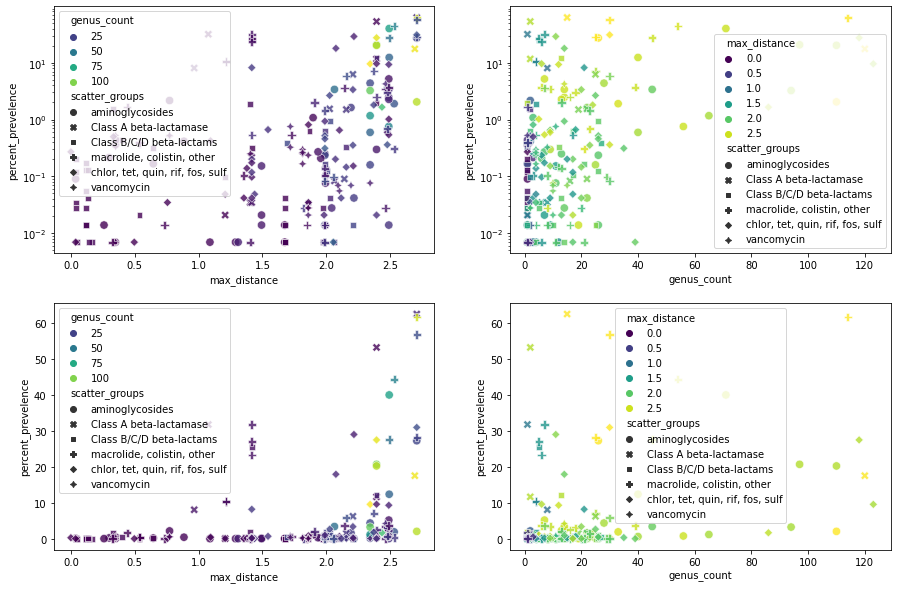

In [87]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
plt.rcParams['svg.fonttype'] = 'none'
ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.scatterplot(data=dist_prev, x="max_distance", y="percent_prevelence", style="scatter_groups", ax=ax[0][0], hue="genus_count", alpha=0.8, palette="viridis", s=70)
sns.scatterplot(data=dist_prev, x="genus_count", y="percent_prevelence", style="scatter_groups", ax=ax[0][1], hue="max_distance", alpha=0.8, palette="viridis", s=70)
sns.scatterplot(data=dist_prev, x="max_distance", y="percent_prevelence", style="scatter_groups", ax=ax[1][0], hue="genus_count", alpha=0.8, palette="viridis", s=70)
sns.scatterplot(data=dist_prev, x="genus_count", y="percent_prevelence", style="scatter_groups", ax=ax[1][1], hue="max_distance", alpha=0.8, palette="viridis", s=70)
plt.savefig(WRK+"rgi_analysis/figures/scatter_prev/exploritory_scatter_plots.svg")
plt.savefig(WRK+"rgi_analysis/figures/scatter_prev/exploritory_scatter_plots.png")

<AxesSubplot:xlabel='max_distance', ylabel='genus_count'>

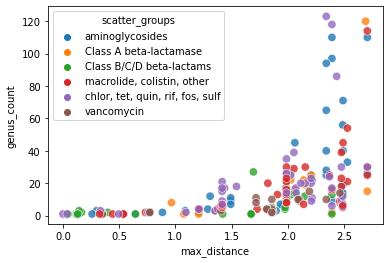

In [89]:
sns.scatterplot(data=dist_prev, x="max_distance", y="genus_count", hue="scatter_groups", alpha=0.8, s=70)

In [61]:
dist_prev[dist_prev["display_name"].isin(["CfiA","CblA","CfxA","CepA"])]

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance,gene_count,percent_prevelence
70,CblA beta-lactamase,CblA,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,CblA-1,Bacteroides;Phocaeicola,2,2.392798,7719.0,53.311693
71,CepA beta-lactamase,CepA,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,cepA,Bacteroides;Escherichia,2,2.392798,1690.0,11.672077
72,CfiA beta-lactamase,CfiA,antibiotic inactivation,Class B1 metallo-beta-lactamase,beta-lactams,A,beta-lactams,Class B/C/D beta-lactams,CcrA,Bacteroides,1,2.392798,286.0,1.975275
75,CfxA beta-lactamase,CfxA,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,CfxA2,Alistipes;Bacteroides;Butyricimonas;Capnocytop...,15,2.707654,9067.0,62.621728
76,CfxA beta-lactamase,CfxA,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,CfxA6,Prevotella,1,1.075696,4608.0,31.825402


In [53]:
dist_prev[(dist_prev["max_distance"]<1.8) & (dist_prev["percent_prevelence"]>5)].sort_values("percent_prevelence",ascending=False)

,AMR Gene Family,display_name,Resistance Mechanism,grouped_family,Antibioitic Types,Grouping,mechansim_and_beta_lactams,scatter_groups,ARO Name,genus_list,genus_count,max_distance,gene_count,percent_prevelence
197,pmr phosphoethanolamine transferase,pmr phosphoethanolamine transferase,antibiotic target alteration,phosphoethanolamine transferase,colisitin,E,antibiotic target alteration,"macrolide, colistin, other",PmrF,Citrobacter;Enterobacter;Escherichia;Klebsiell...,7,1.415958,4610.0,31.839215
76,CfxA beta-lactamase,CfxA,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,CfxA6,Prevotella,1,1.075696,4608.0,31.825402
202,pmr phosphoethanolamine transferase,pmr phosphoethanolamine transferase,antibiotic target alteration,phosphoethanolamine transferase,colisitin,E,antibiotic target alteration,"macrolide, colistin, other",eptA,Enterobacter;Escherichia;Klebsiella;Salmonella...,5,1.415958,3923.0,27.094413
129,ampC-type beta-lactamase,ampC-type,antibiotic inactivation,Class C beta-lactamase,beta-lactams,A,beta-lactams,Class B/C/D beta-lactams,Escherichia coli ampC beta-lactamase,Enterobacter;Escherichia;Klebsiella;Salmonella...,5,1.415958,3689.0,25.478279
204,pmr phosphoethanolamine transferase,pmr phosphoethanolamine transferase,antibiotic target alteration,phosphoethanolamine transferase,colisitin,E,antibiotic target alteration,"macrolide, colistin, other",ugd,Citrobacter;Enterobacter;Escherichia;Klebsiell...,6,1.415958,3378.0,23.330340
203,pmr phosphoethanolamine transferase,pmr phosphoethanolamine transferase,antibiotic target alteration,phosphoethanolamine transferase,colisitin,E,antibiotic target alteration,"macrolide, colistin, other",eptB,Enterobacter;Klebsiella;Providencia;Raoultella,4,1.214154,1515.0,10.463430
196,pmr phosphoethanolamine transferase,pmr phosphoethanolamine transferase,antibiotic target alteration,phosphoethanolamine transferase,colisitin,E,antibiotic target alteration,"macrolide, colistin, other",ArnT,Enterobacter;Klebsiella;Providencia;Raoultella,4,1.214154,1507.0,10.408177
160,fosfomycin thiol transferase,fosfomycin thiol transferase,antibiotic inactivation,fosfomycin thiol transferase,fosfomycin,F,antibiotic inactivation,"chlor, tet, quin, rif, fos, sulf",fosA5,Brenneria;Chimaeribacter;Citrobacter;Cronobact...,21,1.415958,1187.0,8.198080
17,ACI beta-lactamase,ACI,antibiotic inactivation,Class A beta-lactamase,beta-lactams,A,beta-lactams,Class A beta-lactamase,ACI-1,Acidaminococcus;Dialister;Megasphaera;Mitsuoke...,8,0.965332,1168.0,8.066855


In [48]:
print(len(distane_measures["AMR Gene Family"].drop_duplicates()))
print(len(dist_prev["AMR Gene Family"].drop_duplicates()))

46
44


In [180]:
import warnings
warnings.filterwarnings("ignore")

tax_level=["phylum","class","order","family","genus"]

tax="genus_2"
# screen for only the taxa tht have at east a few genomes
total_tax_counts2=genomes_processed.copy().drop_duplicates(["file"])
total_tax_counts2=total_tax_counts2.groupby(tax).size().reset_index(name=tax+"_count")

,genus_2,genus_2_count
0,Abditibacterium,1
1,Abiotrophia,3
2,Absicoccus,1
3,Absiella,7
4,Abyssibacter,1
...,...,...
3259,Zooshikella,5
3260,Zophobihabitans,1
3261,Zunongwangia,5
3262,Zymobacter,2


In [195]:
# select only the taxa which have a minimum number of representatives
min_genomes=10
keep_tax=total_tax_counts2[total_tax_counts2[tax+"_count"]>=min_genomes][tax].to_list()

# start counting up how many taxa each gene rep is present in
gene_rep_count=hit_df_reduced.copy().drop_duplicates(["gene_rep", tax])
gene_rep_count=gene_rep_count[gene_rep_count[tax].isin(keep_tax)]
gene_rep_count=gene_rep_count.groupby(['gene_rep',"AMR Gene Family",'grouped_family']).size().reset_index(name=tax+"_rep_count")
#gene_rep_count=pd.merge(left=gene_rep_count, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')
gene_rep_count.head(2)

,gene_rep,AMR Gene Family,grouped_family,genus_2_rep_count
0,23S rRNA (adenine(2058)-N(6))-methyltransferas...,Erm 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,10
1,AAC(2')-IIa,AAC(2'),aminoglycoside acetyltransferase,14


In [196]:
global_rep_abundance=pd.read_csv(HUMAAN+"publication_tabs/global_humaan/absolute_prevelence/Best_Hit_ARO_absolute_repvelence.txt",sep='\t').rename({"Best_Hit_ARO":"gene_rep"},axis=1)
global_isolate_count=pd.merge(left=gene_rep_count, right=global_rep_abundance[["gene_rep","AMR Gene Family","grouped_family","Best_Hit_ARO_percent_repvelence"]], 
                              on=["gene_rep","AMR Gene Family","grouped_family"], how='outer').fillna(0)
global_isolate_count=pd.merge(left=global_isolate_count, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping","Antibioitic Types","scatter_groups"]], on=["AMR Gene Family"], how='right')
global_isolate_count.head(2)

,gene_rep,AMR Gene Family,grouped_family,genus_2_rep_count,Best_Hit_ARO_percent_repvelence,display_name,Grouping,Antibioitic Types,scatter_groups
0,cfr(D),Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,4.0,0.000000,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other"
1,cfrA,Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,12.0,0.016036,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other"


In [235]:
this_count.loc[this_count["Best_Hit_ARO_percent_repvelence"] == 0, "Best_Hit_ARO_percent_repvelence"] = 0.0001

,gene_rep,AMR Gene Family,grouped_family,genus_2_rep_count,Best_Hit_ARO_percent_repvelence,display_name,Grouping,Antibioitic Types,scatter_groups,rename,regroup
0,cfr(D),Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,4.0,0.000100,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other",zother,zother
1,cfrA,Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,12.0,0.016036,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other",zother,zother
2,cfrC,Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,5.0,0.048108,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other",zother,zother
3,cipA,Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,1.0,0.000100,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other",zother,zother
4,clbA,Cfr 23S ribosomal RNA methyltransferase,23S ribosomal RNA methyltransferase,3.0,0.008018,Cfr ribosomal methyltransferase,I,"streptogramins, chloramphenicols, florfenicols...","macrolide, colistin, other",zother,zother
...,...,...,...,...,...,...,...,...,...,...,...
278,vanHB,vanH; glycopeptide resistance gene cluster,glycopeptide resistance gene cluster,3.0,1.876203,vanH,C,vancomycin,vancomycin,vanH,glycopeptide resistance gene cluster
279,vanHD,vanH; glycopeptide resistance gene cluster,glycopeptide resistance gene cluster,1.0,1.371071,vanH,C,vancomycin,vancomycin,vanH,glycopeptide resistance gene cluster
280,vanHF,vanH; glycopeptide resistance gene cluster,glycopeptide resistance gene cluster,2.0,0.008018,vanH,C,vancomycin,vancomycin,vanH,glycopeptide resistance gene cluster
281,vanHM,vanH; glycopeptide resistance gene cluster,glycopeptide resistance gene cluster,3.0,0.000100,vanH,C,vancomycin,vancomycin,vanH,glycopeptide resistance gene cluster


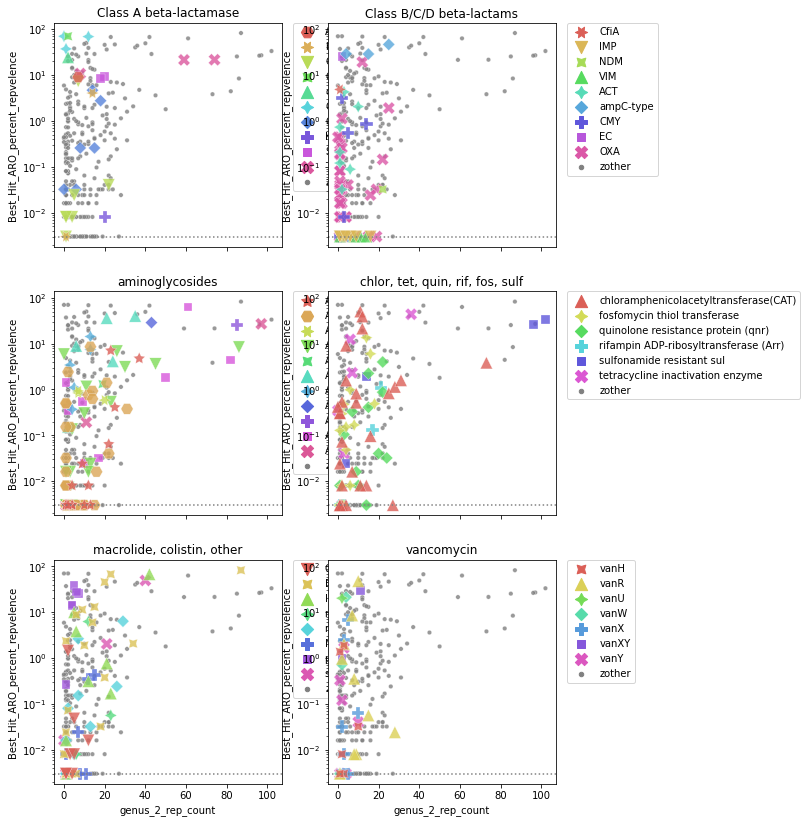

In [262]:
gene_types=global_isolate_count["scatter_groups"].drop_duplicates().sort_values().to_list()
palette="hls"

fig, ax = plt.subplots(3, 2, figsize=(9,14), sharex='col')
plt.rcParams['svg.fonttype'] = 'none'

ax=ax.reshape(6)
for i in range(len(gene_types)):
    gene_type=gene_types[i]
    this_count=global_isolate_count.copy()
    #set zeros to small number so they're not lost
    this_count.loc[this_count["Best_Hit_ARO_percent_repvelence"] == 0, "Best_Hit_ARO_percent_repvelence"] = 0.003
    type_df=this_count[this_count["scatter_groups"]==gene_type]
    disp_names=type_df.sort_values(["scatter_groups","grouped_family","display_name"],key=lambda col: col.str.lower())["display_name"].drop_duplicates().to_list()
    coloring=sns.color_palette(palette,len(disp_names))
    c_dict=dict(zip(disp_names, coloring))
    sizes=dict(zip(disp_names, [150]*len(disp_names)))
    c_dict["zother"]='grey'
    sizes["zother"]=20
    update_names=[]
    update_groups=[]
    for index, row in global_isolate_count.iterrows():
        name=row["display_name"]
        if name in disp_names:
            update_names.append(name)
            update_groups.append(row["grouped_family"])
        else:
            update_names.append('zother')
            update_groups.append('zother')
    this_count["rename"]=update_names
    this_count["regroup"]=update_groups
    
    this_count=this_count.sort_values(["regroup","rename"], ascending=False, key=lambda col: col.str.lower())
        
    sns.scatterplot(data=this_count, x=tax+"_rep_count", y="Best_Hit_ARO_percent_repvelence",
                    hue="rename", palette=c_dict, size='rename', sizes=sizes, hue_order=disp_names+['zother'], alpha=0.8, style="rename", ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[i].set_title(gene_type)
    
 #   ax[i].set_ylim(-10,100)
  #  ax[i].set_xlim(-3,40)
    ax[i].set_yscale('log')
    ax[i].axhline(y=0.003, color='grey', linestyle=':')

plt.savefig(WRK+"rgi_analysis/figures/scatter_prev/psudo_symlog"+tax+"_level_scatter.svg")

## Whihch gene families have the broadest taxonomic spread?

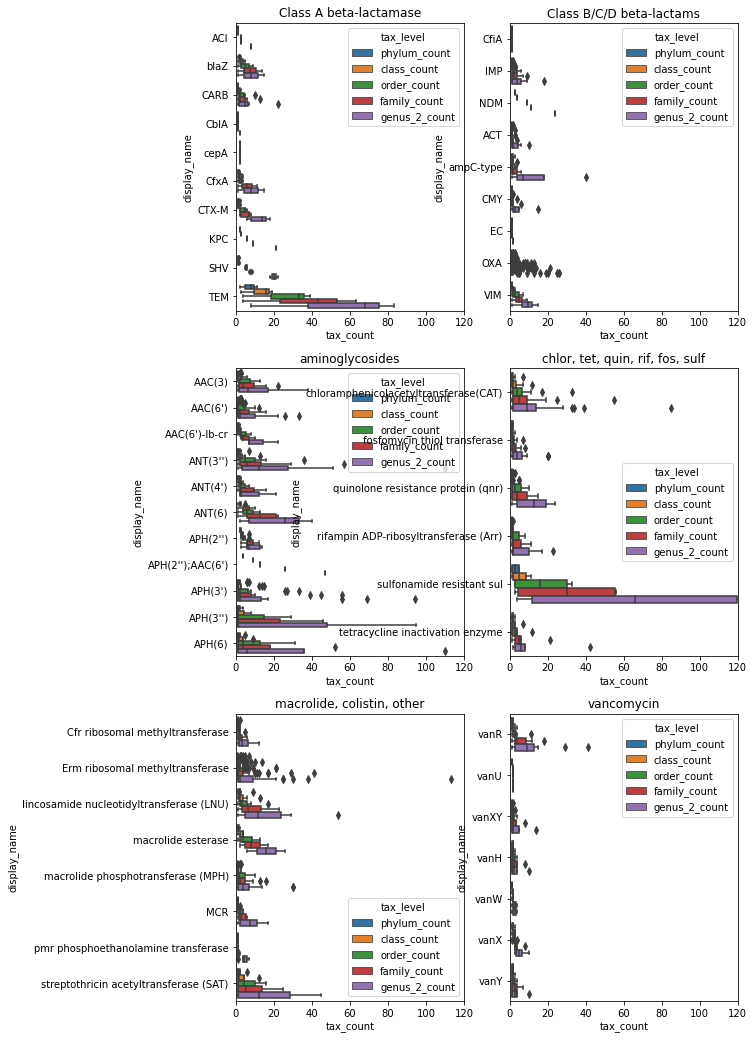

In [466]:
fig, ax = plt.subplots(3, 2, figsize=(9,18))#, sharey='row', sharex='col')
plt.rcParams['svg.fonttype'] = 'none'

ax=ax.reshape(6)
for i in range(len(gene_types)):
    gene_type=gene_types[i]
    this_count=global_isolate_count.copy()
    type_df=this_count[this_count["scatter_groups"]==gene_type]
    type_df=pd.melt(type_df, id_vars=["display_name"], value_vars=type_df.columns[3:8], var_name="tax_level", value_name="tax_count")
    sns.boxplot(data=type_df, y="display_name", x="tax_count", hue="tax_level", orient='h', ax=ax[i])
    ax[i].set_xlim((0,120))
    ax[i].set_title(gene_types[i])
plt.savefig(WRK+"rgi_analysis/figures/misc_metrics/box_taxa_per_family.svg")

In [156]:
global_isolate_count.sort_values(["Grouping","grouped_family","display_name"]), key=lambda col: col.str.lower())

,gene_rep,AMR Gene Family,grouped_family,genus_2_rep_count,Best_Hit_ARO_percent_repvelence,display_name,Grouping,Antibioitic Types,scatter_groups
189,ACI-1,ACI beta-lactamase,Class A beta-lactamase,7.0,8.972097,ACI,A,beta-lactams,Class A beta-lactamase
190,PC1 beta-lactamase (blaZ),blaZ beta-lactamase,Class A beta-lactamase,14.0,4.049070,blaZ,A,beta-lactams,Class A beta-lactamase
191,mecC-type BlaZ,blaZ beta-lactamase,Class A beta-lactamase,1.0,0.000000,blaZ,A,beta-lactams,Class A beta-lactamase
192,CARB-1,CARB beta-lactamase,Class A beta-lactamase,22.0,0.040090,CARB,A,beta-lactams,Class A beta-lactamase
193,CARB-21,CARB beta-lactamase,Class A beta-lactamase,1.0,0.008018,CARB,A,beta-lactams,Class A beta-lactamase
...,...,...,...,...,...,...,...,...,...
363,SAT-3,streptothricin acetyltransferase (SAT),streptothricin acetyltransferase,0.0,0.016036,streptothricin acetyltransferase (SAT),K,streptothricins,"macrolide, colistin, other"
364,sul1,sulfonamide resistant sul,sulfonamide resistant sul,96.0,26.443233,sulfonamide resistant sul,L,sulfonamide,"chlor, tet, quin, rif, fos, sulf"
365,sul2,sulfonamide resistant sul,sulfonamide resistant sul,102.0,33.410840,sulfonamide resistant sul,L,sulfonamide,"chlor, tet, quin, rif, fos, sulf"
366,sul3,sulfonamide resistant sul,sulfonamide resistant sul,14.0,1.908275,sulfonamide resistant sul,L,sulfonamide,"chlor, tet, quin, rif, fos, sulf"


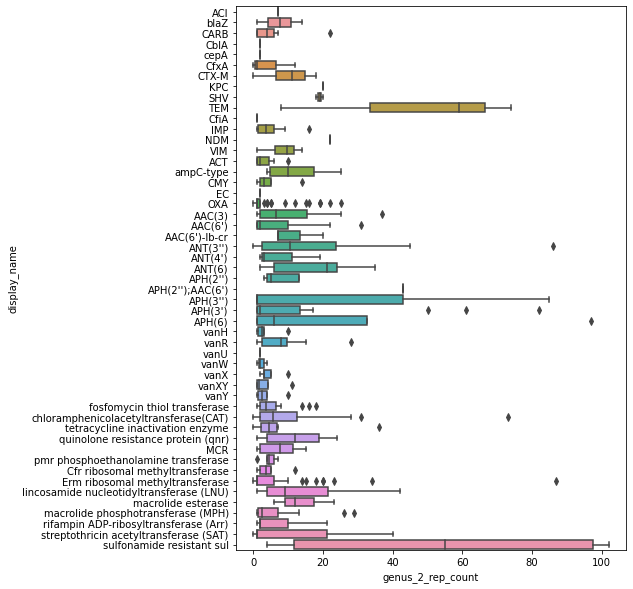

In [162]:
fig, ax = plt.subplots(figsize=(7,10))
plt.rcParams['svg.fonttype'] = 'none'
sns.boxplot(data=global_isolate_count.sort_values(["Grouping","grouped_family","display_name"], key=lambda col: col.str.lower()), y="display_name", x="genus_2_rep_count", orient='h')
plt.savefig(WRK+"rgi_analysis/figures/misc_metrics/box_genus_per_family.svg")

### Is there a relation between number of genomes and number of genes found?

In [484]:
tax_level=["phylum","class","order","family","genus_2"]
tax_dict=dict(zip(tax_level,range(5)))
tax="order"

total_tax_counts3=genomes_processed.copy().drop_duplicates(["file"])
total_tax_counts3=total_tax_counts3.groupby([tax]).size().reset_index(name="genome_count")
total_tax_counts3=pd.merge(left=total_tax_counts3, right=genomes_processed[[tax,'pathogen']].sort_values('pathogen', ascending=False).drop_duplicates(tax), on=tax, how='left')

# start counting up how many taxa each gene rep is present in

### here I remove other gene fams that we didn't look at
tax_rep_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')
tax_rep_count=tax_rep_count.copy().drop_duplicates([tax,"gene_rep"])
#tax_rep_count=tax_rep_count[tax_rep_count[tax].isin(keep_tax)]
tax_rep_count=tax_rep_count.groupby(tax_level[:tax_dict[tax]+1]).size().reset_index(name=tax+"_gene_count")
tax_rep_count=pd.merge(left=tax_rep_count, right=total_tax_counts3, on=tax, how='left').fillna(0)
tax_rep_count.head(2)

patho_rename=[]
for patho in tax_rep_count["pathogen"]:
    if patho: patho_rename.append('pathogenic')
    else: patho_rename.append('non-pathogenic')
tax_rep_count["pathogen"]=patho_rename

tax_rep_count.head(2)

,phylum,class,order,order_gene_count,genome_count,pathogen
0,Actinobacteria,Actinomycetia,Actinomycetales,10,396,pathogenic
1,Actinobacteria,Actinomycetia,Actinopolysporales,1,13,non-pathogenic


Text(0.5, 0, 'Total Genomes Processed')

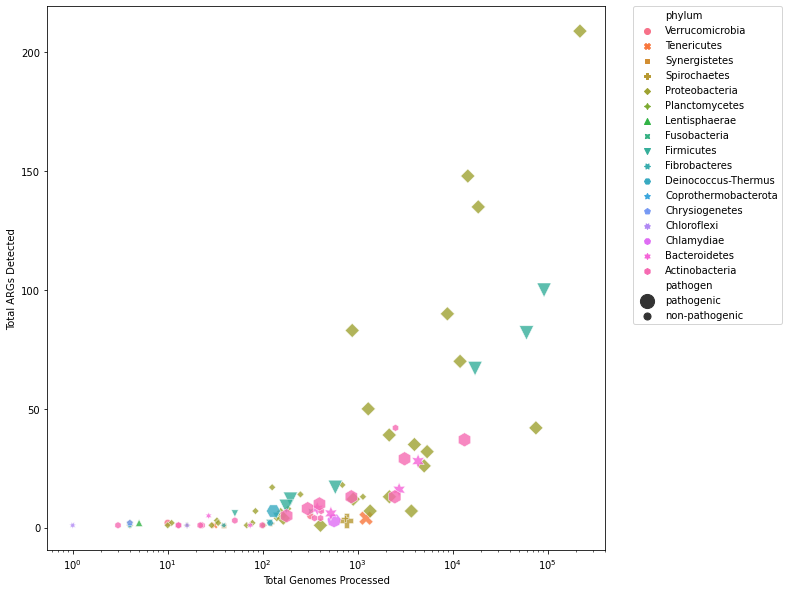

In [485]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams['svg.fonttype'] = 'none'
#tax_rep_count=tax_rep_count[tax_rep_count["phylum"]!="Proteobacteria"]
ax = sns.scatterplot(data=tax_rep_count.sort_values("phylum", ascending=False), x="genome_count", y=tax+"_gene_count", hue="phylum", size='pathogen', style='phylum', 
                     size_order=["pathogenic","non-pathogenic"], sizes=(50,200), alpha=0.8)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xscale('log')
ax.set_ylabel("Total ARGs Detected")
ax.set_xlabel("Total Genomes Processed")

#plt.savefig(WRK+"rgi_analysis/figures/misc_metrics/scatter_linear_select_fam_args_vs_total_genomes.svg")

## Rarefaction of genomes maybe???

In [89]:
#### Generates a rarefation for the givin taxa at the givin taxonomic level
def sample_tax(count_df, level, taxa, min_sample=10, scale=0.1, reps=5, max_genomes=1000000):
    import statistics
    from random import sample
    
    rare_out=[]
    this_tax=count_df[count_df[level]==taxa]
    all_files=this_tax["file"].drop_duplicates().to_list()

    stop=len(all_files)
    if stop > max_genomes: stop=max_genomes
    i=5
    while i < stop:  
        these_samples=[]
        for x in range(reps):
            file_sample=sample(all_files, int(i))
            sample_df=this_tax[this_tax["file"].isin(file_sample)]
            count=len(sample_df["gene_rep"].drop_duplicates())
            these_samples.append(count)
        mean_sample=statistics.mean(these_samples)
        rare_out.append([taxa, i, mean_sample])      
        i=i+i*scale
    
    return rare_out

In [ ]:
selected_gene_fams=pd.read_csv(WRK+"rgi_analysis/publication_tabs/selected_gene_fams_V1.txt",sep='\t')
rare_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')

In [113]:
import tqdm as tqdm
level="class"
minimum_genomes=500
tax_counts=rare_count.drop_duplicates(["file",level]).groupby(level).size().reset_index(name="count")
tax_list=tax_counts[tax_counts["count"]>=minimum_genomes][level].to_list()
print(len(tax_list))

output_rare=[]
for taxa in tqdm.tqdm(tax_list):
    rare_out=sample_tax(rare_count, level, taxa, min_sample=5, scale=0.05, reps=15, max_genomes=1000000)
    output_rare=output_rare+rare_out

  0%|          | 0/14 [00:00<?, ?it/s]

14


100%|██████████| 14/14 [14:05<00:00, 60.39s/it]


In [114]:
tax_df_rare=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"])
#tax_df_rare.to_csv(WRK+"rgi_analysis/figures/rarefaction/"+level+"_15rep_rarefaction_tab.txt", sep='\t')

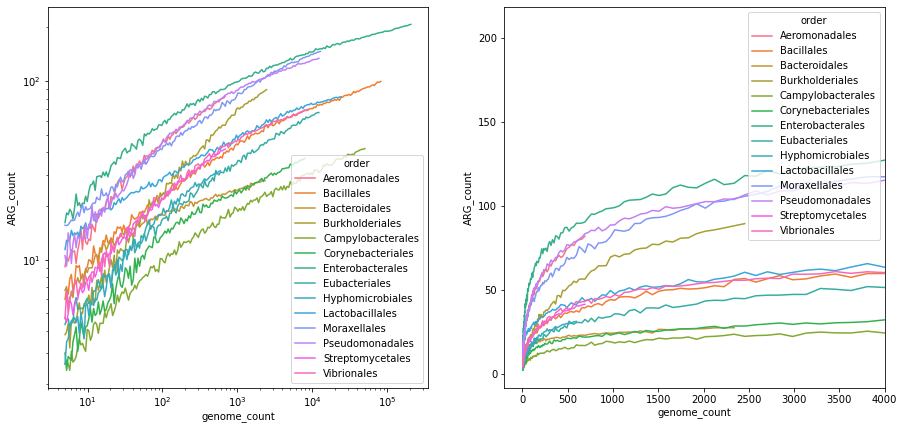

In [134]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=tax_df_rare, x="genome_count", y="ARG_count", hue='order', ax=ax[0])
sns.lineplot(data=tax_df_rare, x="genome_count", y="ARG_count", hue='order', ax=ax[1])
ax[1].set_xlim((-200,4000))

ax[0].set_xscale('log')
ax[0].set_yscale('log')

#plt.savefig(WRK+"rgi_analysis/figures/rarefaction/"+level+"_15rep_rarefaction_tab.png")

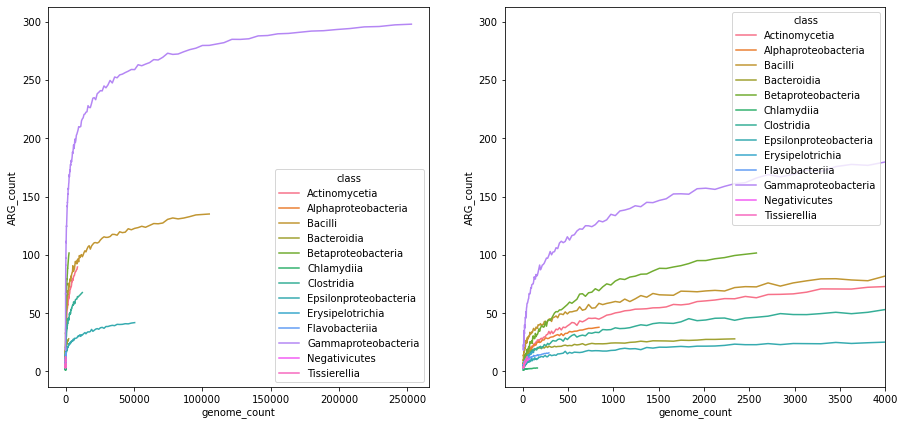

In [265]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=class_rare, x="genome_count", y="ARG_count", hue=level, ax=ax[0])
sns.lineplot(data=class_rare, x="genome_count", y="ARG_count", hue=level, ax=ax[1])
ax[1].set_xlim((-200,4000))

#ax[0].set_xscale('log')
#ax[0].set_yscale('log')

plt.savefig(WRK+"rgi_analysis/figures/rarefaction/"+level+"_15rep_rarefaction_tab.svg")

## Use all genes and not just the selected

In [126]:
import tqdm as tqdm
level="class"
minimum_genomes=500
tax_counts=hit_df_reduced.drop_duplicates(["file",level]).groupby(level).size().reset_index(name="count")
tax_list=tax_counts[tax_counts["count"]>=minimum_genomes][level].to_list()
print(len(tax_list))

output_rare=[]
for taxa in tqdm.tqdm(tax_list):
    rare_out=sample_tax(hit_df_reduced, level, taxa, min_sample=50, scale=0.05, reps=2, max_genomes=1000000)
    output_rare=output_rare+rare_out

  0%|          | 0/9 [00:00<?, ?it/s]

9


100%|██████████| 9/9 [02:30<00:00, 16.67s/it]


(-200.0, 4000.0)

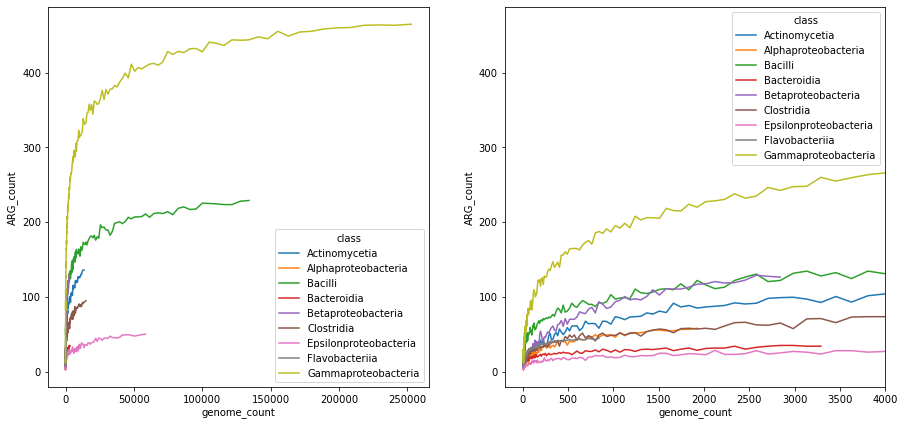

In [127]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[0])
sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[1])
ax[1].set_xlim((-200,4000))

In [118]:
selected_gene_fams=pd.read_csv(WRK+"rgi_analysis/publication_tabs/selected_gene_fams_V1.txt",sep='\t')
rare_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')
rare_count=rare_count.drop_duplicates(["file","AMR Gene Family"])
import tqdm as tqdm
level="class"
minimum_genomes=500
tax_counts=rare_count.drop_duplicates(["file",level]).groupby(level).size().reset_index(name="count")
tax_list=tax_counts[tax_counts["count"]>=minimum_genomes][level].to_list()
print(len(tax_list))

8


In [120]:
output_rare=[]
for taxa in tqdm.tqdm(tax_list):
    rare_out=sample_tax(rare_count, level, taxa, min_sample=50, scale=0.05, reps=1, max_genomes=1000000)
    output_rare=output_rare+rare_out

100%|██████████| 8/8 [00:50<00:00,  6.35s/it]


(-200.0, 4000.0)

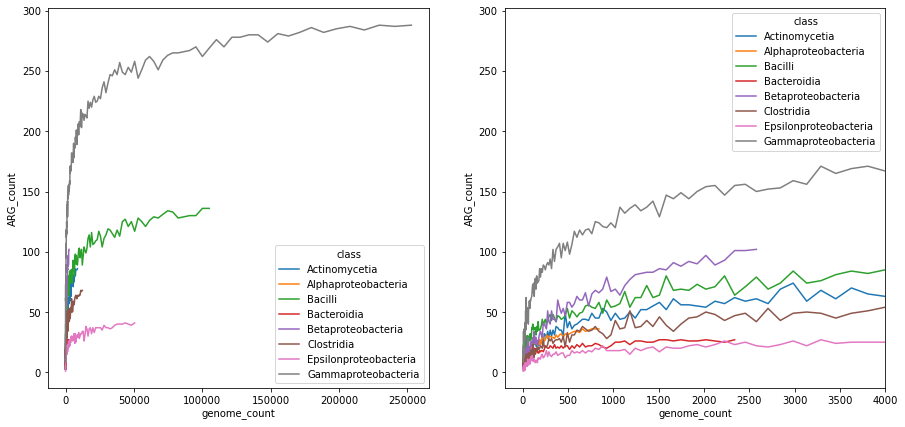

In [121]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[0])
sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[1])
ax[1].set_xlim((-200,4000))

In [122]:
rare_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')

In [123]:
rare_count["gene_rep"].drop_duplicates()

0             clbA
500           cfrA
731           clbB
800           cfrC
1457          clcD
            ...   
2025766    OXA-269
2025786      VIM-1
2026338      VIM-2
2027181     VIM-19
2027495      VIM-7
Name: gene_rep, Length: 462, dtype: object

In [124]:
rare_count["AMR Gene Family"].drop_duplicates()

0              Cfr 23S ribosomal RNA methyltransferase
1696           Erm 23S ribosomal RNA methyltransferase
55807                                           AAC(3)
77259                                          AAC(6')
197149                                   AAC(6')-Ib-cr
204586                                        ANT(3'')
284105                                         ANT(4')
291875                                          ANT(6)
307179                                        APH(2'')
308744                               APH(2''); AAC(6')
322239                                         APH(3')
385108                                        APH(3'')
433361                                          APH(6)
489339         chloramphenicol acetyltransferase (CAT)
532456                              ACI beta-lactamase
532490                             blaZ beta-lactamase
557429                             CARB beta-lactamase
564883                             CblA beta-lactamase
565118    

In [291]:
van_fams=["vanH; glycopeptide resistance gene cluster","vanX; glycopeptide resistance gene cluster","vanY; glycopeptide resistance gene cluster"]
van_hits=hit_df_reduced[hit_df_reduced["Drug Class"]=="glycopeptide antibiotic"]
van_hits=van_hits[van_hits["class"]=="Gammaproteobacteria"]
van_hits=van_hits[van_hits["AMR Gene Family"]!="Bleomycin resistant protein"]
#van_hits.groupby(["file"]).size().reset_index().sort_values("file")

In [295]:
van_hits.drop_duplicates("file").groupby(["tax_name_2"]).size().reset_index().sort_values(0, ascending=False)

,tax_name_2,0
1,Klebsiella pneumoniae,15
4,Pseudomonas aeruginosa,2
0,Acinetobacter baumannii,1
2,Klebsiella quasipneumoniae,1
3,Klebsiella variicola,1
5,Pseudomonas stutzeri,1


In [293]:
van_hits.drop_duplicates("file").groupby(["AMR Gene Family"]).size().reset_index().sort_values(0, ascending=False)

,AMR Gene Family,0
4,vanY; glycopeptide resistance gene cluster,8
0,glycopeptide resistance gene cluster; van ligase,4
2,vanH; glycopeptide resistance gene cluster,4
1,glycopeptide resistance gene cluster; vanR,3
3,vanX; glycopeptide resistance gene cluster,1
5,vanZ; glycopeptide resistance gene cluster,1


In [297]:
tax_counts

,class,count
0,Acidithiobacillia,1
1,Actinomycetia,13773
2,Alphaproteobacteria,1942
3,Anaerolineae,2
4,Bacilli,135229
5,Bacteroidia,3434
6,Balneolia,3
7,Betaproteobacteria,2977
8,Chlamydiia,408
9,Chrysiogenetes,1


In [311]:
beep=["CfiA beta-lactamase","cepA beta-lactamase","CblA beta-lactamase"]
kpc=hit_df_reduced[hit_df_reduced["AMR Gene Family"].isin(beep)]
kpc=kpc[kpc["class"]!="Bacteroidia"]
kpc

,file,gene_rep,card_gene,Drug Class,Resistance Mechanism,AMR Gene Family,grouped_family,mechansim_and_beta_lactams,antibioitic,clinical,...,class,order,family,genus,species,tax_name,tax_name_genus,genus_2,species_2,tax_name_2
3541109,GCA_016695135.1_PDT000936459.1_genomic.txt,cepA,cepA,cephalosporin,antibiotic inactivation,cepA beta-lactamase,Class A beta-lactamase,beta-lactams,beta-lactams,NaN,...,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,NaN,Escherichia coli,Escherichia,Escherichia,coli,Escherichia coli
